In [28]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 17 18:45:12 2019

@author: jezsadler
"""
# Import libraries for math and plotting.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in data.
q2_data = pd.read_csv("molocoq2.csv",header=None)

# Label columns.
q2_data.columns = ["A","B","C"]

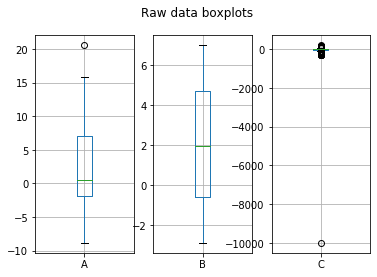

In [29]:
# Look at the shape of data.
boxplots, (bx1, bx2, bx3) = plt.subplots(1, 3)
boxplots.suptitle('Raw data boxplots')
q2_data.boxplot(column="A",ax=bx1)
q2_data.boxplot(column="B",ax=bx2)
q2_data.boxplot(column="C",ax=bx3)

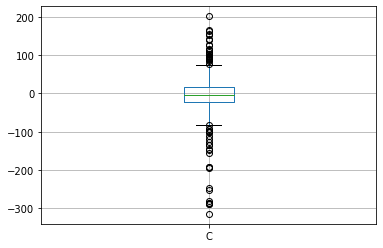

In [30]:
# C has one massive outlier, let's remove it.
q2_data_corrected = q2_data[q2_data["C"] != -10000]

# Check again.
q2_data_corrected.boxplot(["C"])

In [31]:
# Still several outliers, but less extreme. 

# Look for correlations between the variables.
q2_data_corrected.corr()

,A,B,C
A,1.000000,-0.187059,0.010536
B,-0.187059,1.000000,-0.618516
C,0.010536,-0.618516,1.000000


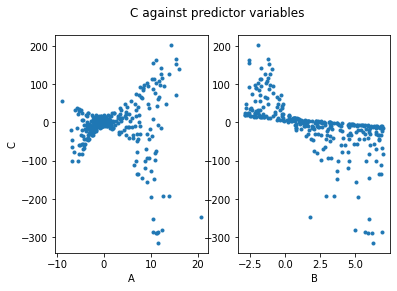

In [32]:
# So we have moderate negative (-0.61) between B and C, weak negative (-0.18)
# between A and B, and pretty much none (0.01) between A and C. Let's plot 
# A and B against C to get a visual sense.

scatterplots, (sc1, sc2) = plt.subplots(1, 2)
scatterplots.suptitle("C against predictor variables")
sc1.set_ylabel("C")
sc1.set_xlabel("A")
sc2.set_xlabel("B")

sc1.plot(q2_data_corrected["A"],q2_data_corrected["C"],".")
sc2.plot(q2_data_corrected["B"],q2_data_corrected["C"],".")

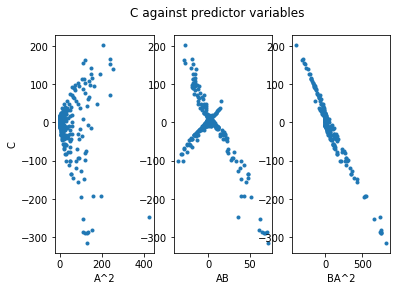

In [34]:
# We see clear patterns in both of these. B has a linear edge, with data points above it for negative
# values of B, and below it for positive values. A has a hyperbolic envelope. This suggests that there
# are non-linear relationships between C and A or B.

# Logarithms are often a good start, but in this case we have lots of negative values so logarithms 
# won't work.
# Try some other transformations and combinations:

q2_data_corrected.loc[:,"A2"] = q2_data_corrected["A"]*q2_data_corrected["A"]
q2_data_corrected.loc[:,"AB"] = q2_data_corrected["A"]*q2_data_corrected["B"]
q2_data_corrected.loc[:,"BA2"] = q2_data_corrected["A"]*q2_data_corrected["A"]*q2_data_corrected["B"]


scatterplots, (sc1, sc2, sc3) = plt.subplots(1, 3)
scatterplots.suptitle("C against predictor variables")
sc1.set_ylabel("C")
sc1.set_xlabel("A^2")
sc2.set_xlabel("AB")
sc3.set_xlabel("BA^2")

sc1.plot(q2_data_corrected["A2"],q2_data_corrected["C"],".")
sc2.plot(q2_data_corrected["AB"],q2_data_corrected["C"],".")
sc3.plot(q2_data_corrected["BA2"],q2_data_corrected["C"],".")

In [35]:
# BA^2 looks really good as a predictor for C. Let's check those correlation coefficients.

q2_data_corrected.corr()

,A,B,C,A2,AB,BA2
A,1.000000,-0.187059,0.010536,0.799620,0.374292,0.183021
B,-0.187059,1.000000,-0.618516,-0.204651,0.207967,0.490593
C,0.010536,-0.618516,1.000000,-0.040545,-0.684590,-0.975801
A2,0.799620,-0.204651,-0.040545,1.000000,0.212975,0.206018
AB,0.374292,0.207967,-0.684590,0.212975,1.000000,0.761038
BA2,0.183021,0.490593,-0.975801,0.206018,0.761038,1.000000


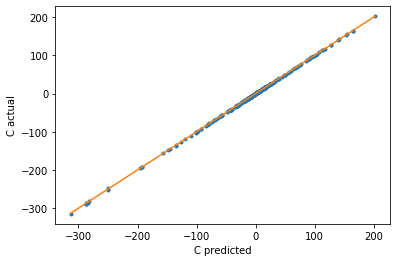

SSE: [33.57249108]


In [50]:
# So BA^2 looks *really* good at -0.98. I tried a few different models, but landed
# on this one: C = m1 A + m2 B + m3 BA^2 + const:

# Prep data
X = q2_data_corrected[["A","B","BA2"]]
y = q2_data_corrected["C"]

# Add constant term:
Xc = pd.concat([X,pd.Series(np.ones(len(X)),index=X.index)],axis=1)

# Fit model using least squares:
model = np.linalg.lstsq(Xc,y,1)

# Get predictions from model.
y_hat = model[0][0]*X["A"]+model[0][1]*X["B"]+model[0][2]*X["BA2"]+model[0][3]

# Plot actuals against predictions:
fig = plt.figure()
ax = plt.axes()
plt.plot(y_hat,y,".") 
ax.set_xlabel("C predicted")
ax.set_ylabel("C actual")

plt.plot((min(y_hat),max(y_hat)),(min(y_hat),max(y_hat)))
plt.show()

print("SSE:",model4[1])

In [66]:
print("C = %.1f A + %.1f B + %.1f BA^2 + %.1f" % (model4[0][0],model4[0][1],model4[0][2],model4[0][3]))

C = 2.0 A + -3.0 B + -0.4 BA^2 + 10.0


Text(0, 0.5, 'Residuals')

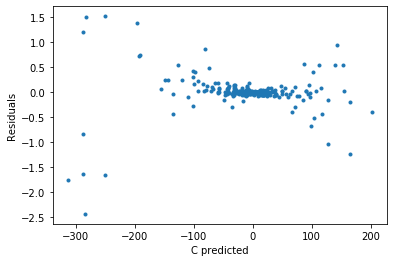

In [68]:
# This looks good enough for our purposes - most of the other models I looked at had SSE in
# the 10,000s. Let's check the residuals:
resids = y - y_hat

fig = plt.figure()
ax = plt.axes()
plt.plot(y_hat,resids,".") 
ax.set_xlabel("C predicted")
ax.set_ylabel("Residuals")

In [69]:
# This is showing heteroscedasticity - the residuals are larger for higher values of C,
# suggesting that additional transformations would be appropriate.
# However, the magnitude of the residuals is very small, so I would say that this model
# is good enough.